# Product Recommendation of an Online Sales

This time I have taken another database from Kaggle which contains the online sales record of a company in 2009. Based on the purchase record of each customer, I want to use their purchase pattern to develop a recommendation system. 

This Jupyter Notebook contains the following part:
1. Basic extraction of statistical features 
2. Develop the customer purchase matrix
3. Application of customer purchase matrix for prediction

Data taken from 
https://www.kaggle.com/mathchi/online-retail-ii-data-set-from-ml-repository

Prepared by Shing Chi Leung at 26 May 2021

## Basic extraction of statistical features 

I will first read the file and extract the principle features about the data. 

In [1]:
import pandas as pd

In [2]:
df = pd.read_excel("Kaggle_Retail.xlsx")

In [3]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

The data is well cleaned that require no further data cleaning. 

Let us take a look at the basic structure of the database.

In [4]:
df.shape

(525461, 8)

In [5]:
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


The datafile is large, so I will find some ways to decrease the database size. First I will remove the rows where there are empty components. This applies to in particular to the "Customer ID" column as we need the customer ID to build the buying pattern. 

In [6]:
df.dropna(inplace=True)
df.shape

(417534, 8)

In [7]:
df["Cost"] = df["Quantity"] * df["Price"]
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Cost
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


Then I will group the dataframe by the customer ID, so that each sub-group contains the purchase record of one customer, and then I calculate who buy the most. 

In [16]:
df_customer = df.groupby("Customer ID")["Cost"].agg(sum).sort_values(ascending=True)
df_customer.head(5)

Customer ID
17399.0   -25111.09
12918.0   -10953.50
15849.0    -5876.34
15760.0    -5795.87
16981.0    -4620.86
Name: Cost, dtype: float64

In [15]:
df_customer.describe()

count      4383.000000
mean       1904.679118
std        8519.369281
min      -25111.090000
25%         285.260000
50%         655.940000
75%        1645.690000
max      341776.730000
Name: Cost, dtype: float64

I notice that there are negative number as the refund is also counted as one transaction. In that case, I will only consider customers who really "buy" things from this online shop, i.e. having a positive expense. 

In [19]:
df_customer = df_customer[df_customer > 0]
df_customer.shape

(4281,)

Now the dataframe is sufficiently reduced. We will use this as the principle database. First let us look at how much each customer spent in 2009. 

<AxesSubplot:title={'center':'Histogram of customer total expense'}, ylabel='Frequency'>

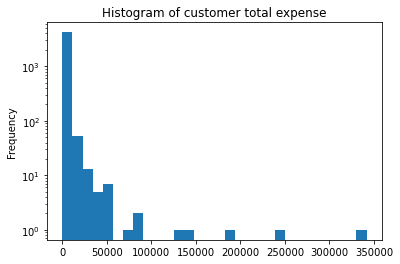

In [33]:
df_customer.plot.hist(bins=30,logy=True, title="Histogram of customer total expense")

It suffices to observe that the frequency decreases exponential against the total budget. Basically most customers only buy below 10000 dollars. In the following part, I will further pick customers who spend more than 5000 dollars. This ensures that the customers have bought a number of products so that there is a higher chance for having a recognizable pattern. There are other ways for visualizing the data, including. 

1. Distribution of purchase in different countries
2. Clustering of purchase in the basis of time
3. Buying frequency vs. buying order size
and so on. 

However, this notebook is not about the data analysis so I will skip this part. 
For convenience, I defined the customers who spent more than 5000 dollars as high customer below. 

In [36]:
df_high_customer = df_customer[df_customer>5000].index
df_high_customer[:5]

Float64Index([13869.0, 15125.0, 13069.0, 17146.0, 14769.0], dtype='float64', name='Customer ID')

In [37]:
df = df[df["Customer ID"].isin(df_high_customer)]
df.shape

(126658, 9)

The final dataframe is almost 1/5 of the original one. In the refined one, customers with significant purchase records, and with a complete details of transaction are remained for analysis. Now we can build a pivot table to record, which customers have bought which kind of items. 

## Develop the customer purchase matrix

I will set up a pivot table so that for each product item, I will know who has bought the item and the amount. 

In [43]:
pivot_table = pd.pivot_table(data=df, values="Quantity", columns="Customer ID", index="StockCode")
pivot_table.fillna(0, inplace=True)
pivot_table.shape

(3693, 265)

In [44]:
pivot_table.head(5)

Customer ID,12357.0,12380.0,12409.0,12415.0,12433.0,12435.0,12437.0,12471.0,12472.0,12476.0,...,18052.0,18087.0,18092.0,18102.0,18172.0,18223.0,18225.0,18226.0,18251.0,18260.0
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,12.0,0.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,...,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,200.0,0.0
10080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10120,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This will form the essential high dimensional database (3695x265) where one vector contains the magnitude of each customer based on the past purchase record. But it is a very high dimensional space, so I will lower the dimension by the PCA/Truncated SVD.

In [90]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [91]:
purchase_mat = pivot_table.to_numpy()
purchase_mat[:5]

array([[ 12.,   0.,  96., ...,   0., 200.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

I will include both the computation by the PCA decomposition and the truncated SVD decomposition to see how different the two approach predict in their recommendation. 

In [92]:
# PCA
pca = PCA(n_components=20)
pca.fit(purchase_mat)
print(pca.explained_variance_ratio_)

# truncated SVD
tsvd = TruncatedSVD(n_components=20)
tsvd.fit(purchase_mat)
print(tsvd.explained_variance_ratio_)

[0.65673257 0.15183751 0.09306701 0.0139293  0.01273669 0.01058661
 0.0065464  0.00585966 0.00487715 0.0041156  0.00403129 0.00293142
 0.00281186 0.00279885 0.00180978 0.00169534 0.00154428 0.00134201
 0.00127684 0.00107192]
[0.65670265 0.15182734 0.09306658 0.01390825 0.01240611 0.01077796
 0.00658675 0.00591606 0.0048918  0.00415448 0.00405042 0.00293143
 0.00281002 0.00280541 0.0018118  0.00169601 0.00154502 0.00134208
 0.00127687 0.00107599]


By the number it shows that whether or not the data is centered has very small effect to the decomposition process. In both case, we develop a kernel to lower the 265-dimension vector down to a 20-dimensional one. 

## Application of customer purchase matrix for prediction

Now we will use this decomposition to do the prediction. FIrst we will transform all product into this 20-dimensional vectors using the kernel. 

In [59]:
good_mat = pca.transform(purchase_mat)

In [60]:
print(good_mat[:5])

[[-5.24806245e+01 -2.18120736e+01  2.62594716e+00 -2.01569232e+01
   2.60749146e+01  2.07056591e+02 -2.62683891e+01  1.34494812e+02
  -6.96891444e+01  6.46754732e+01 -3.30549044e+01 -7.06926109e+00
   1.05930866e+01 -2.37819700e+01  2.41002926e+01 -3.96151384e+01
  -5.25821673e+00 -8.91307785e-01 -3.04126113e+00 -1.78595688e+01]
 [-5.34148695e+01 -2.38625657e+01 -1.11782801e+01 -2.12026905e+00
  -7.22115716e+00 -2.69010896e+01 -1.39099981e+01 -1.08962646e+01
  -6.30506216e+00  9.05628169e+00 -7.31098455e+00  1.16465062e-01
  -1.09699726e+00 -3.29185884e+00 -2.51475886e+00  1.37114547e+00
   1.48648672e+00 -5.00326516e-01 -5.53932933e-01  3.74512904e+00]
 [-5.33956047e+01 -2.38285169e+01 -1.11533920e+01 -2.20130109e+00
  -7.14293884e+00 -2.64748306e+01 -1.40758408e+01 -9.87097843e+00
  -5.22649137e+00  8.58366086e+00 -7.42909453e+00  9.02500170e-01
  -1.38823244e+00 -3.57683024e+00 -2.48067234e+00  1.45724937e+00
   9.75543995e-01 -2.67145637e-01  2.71125285e-01  3.24918282e+00]
 [-5.34

We will use the cosine similarity to determine how close any two vectors are. The score will mean how close any two items are in terms of customers who have bought them. THe closer the two items are, the more likely the same group of customers will buy. We can use this as our recommendation to make the customers aware of the existence of these products. 

In [57]:
from sklearn.metrics.pairwise import cosine_similarity

In [61]:
score = cosine_similarity(purchase_mat)

I pick the top 6 items with the highest scores (the top one must be the original item itself by definition). Since the argsort gives the index of the item, not its StockID, I will need to convert it first. 

In [86]:
import numpy as np
choices_arg = np.argsort(score[1000])[-6:]

In [87]:
choices_ID = [pivot_table.iloc[i].name for i in choices_arg]
choices_ID

[85089, 47598, 20699, 85202, '84931B', 21884]

These IDs are the StockID which has the closet relation to the original item (ID 21884). 

Next, we will need to build the Product table which contains the StockID and its description. This will form our catalogue of products. We will again use the groupby method to collect all purchasable items in the dataframe. 

In [80]:
df_product = df.groupby("StockCode").head(1)
df_product = df_product.drop(["Invoice", "Quantity", "InvoiceDate", "Customer ID", "Country", "Cost"], axis=1)
df_product.shape

(3693, 3)

In [88]:
df_product[df_product["StockCode"].isin(choices_ID)]

,StockCode,Description,Price
6382,85089,CANDY SPOT BUNNY,2.95
11274,47598,NEW ENGLAND EGG WARMER,0.55
12642,20699,MOUSEY LONG LEGS SOFT TOY,2.55
32501,21884,CAKES AND BOWS GIFT TAPE,0.65
75676,85202,HANGING WOOD AND FELT HEART,0.42
77366,84931B,BLUE SCOTTIE DOG W FLOWER PATTERN,2.55


This forms the recommendation we needed for this mini-project. We will need to recommend the following:

1. ID 85089: Candy Spot Bunny
2. ID 47598: New England Egg Warmer
3. ID 20699: Mousey Long Legs Soft Toy
4. ID 85202: Hanging Wood and Felt Heart
5. ID 84931B: Blue Scottie Dog with Flower Pattern

Further works can be done on this dataframe by classifying the items according to the description. And then when we use the recommendation system, we only pick those within the same category, this will help customer select their favourite choice without diverging their original shopping plan. 

Another direction will be to build the recommendation based on the shopping habit at different time. This is make sure the recommendation system will not naively introduce winter items in the summer, or vice versa. 